<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом ноутбуке нам предстоит построить несколоько нейронных сетей с помощью библиотеки Pytorch. На нескольких датасетах: make_moons, MNIST







In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms as tfs
from torchvision.datasets import MNIST

import cv2

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [ ]:
y


array([1, 0, 0, ..., 1, 0, 1])

In [ ]:
X[:3]

array([[ 0.45549318, -0.12550304],
       [-0.70421731,  0.04130827],
       [ 0.41379864,  0.79132194]])

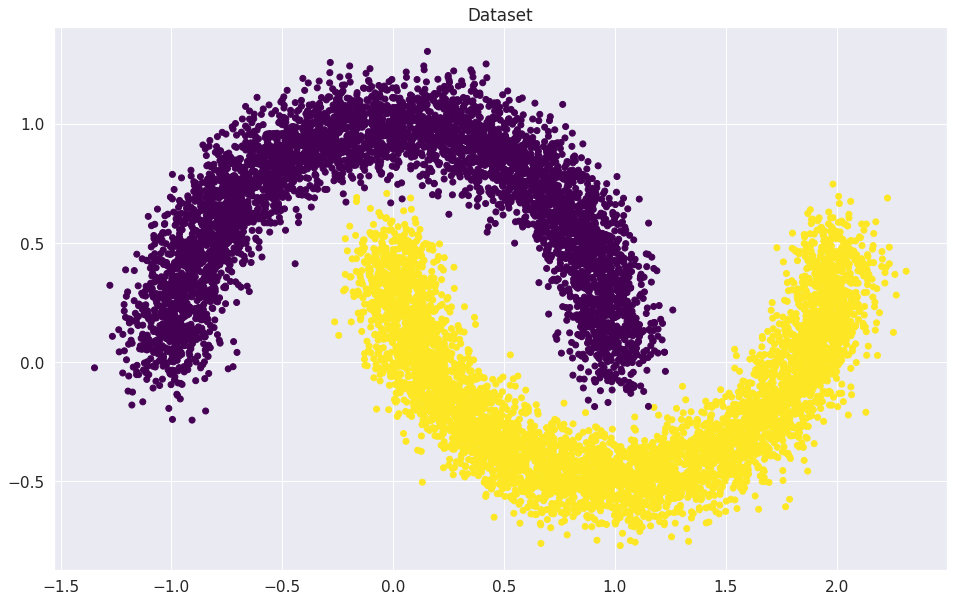

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
Создадим тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Реализация логистической регрессии

Необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear`. Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
t = torch.randn(2,3) 
x = torch.randn(2,3)  
x, t

(tensor([[-0.3006,  0.0548, -0.5448],
         [ 0.8569,  0.5184, -0.4813]]), tensor([[-0.5416,  1.3845,  0.3137],
         [-0.5501, -0.3628,  1.3067]]))

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

        
    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
print("Количество обучаемых параметров: ", sum(p.numel() for p in linear_regression.parameters()))

Количество обучаемых параметров:  3


3 параметра: 2 W и 1 bias




### Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = 1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.34375
Iteration: 100
Batch accuracy: 0.78125
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.875
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8203125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


Для того, чтобы алгоритм сошелся, потребовавлось:

In [ ]:
print(f"{it + epoch * len(train_dataloader)} итераций")

814 итераций


### Визуализируем результаты

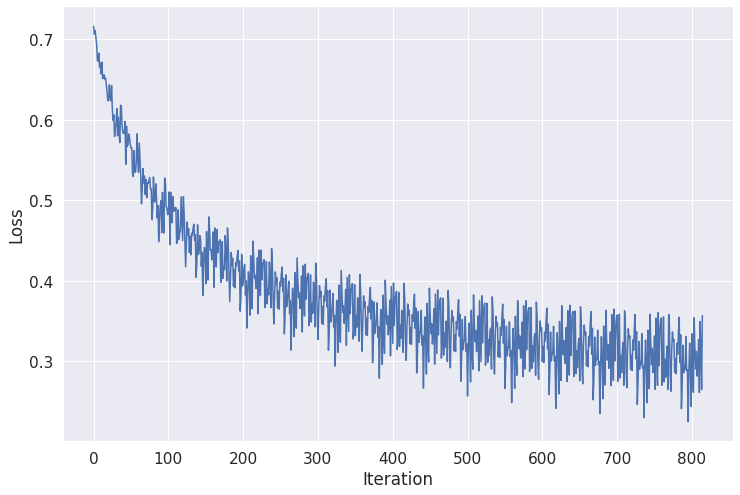

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

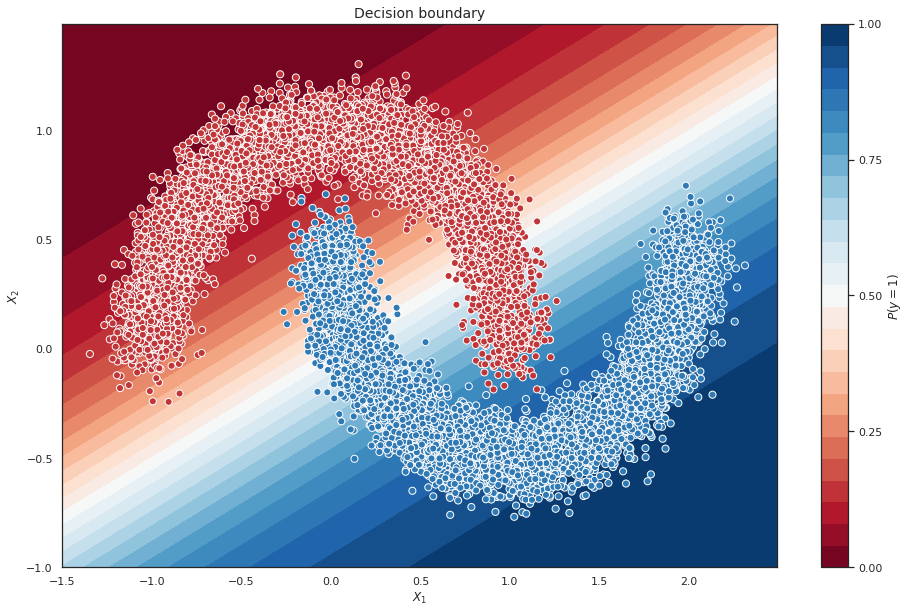

In [ ]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Реализуем predict и посчитаем accuracy на test.

In [ ]:
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  model(x_batch)
        probabilities = 1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long) 
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
prediction = predict(val_dataloader,linear_regression)


acc = accuracy_score(y_val_t, prediction) 
acc

0.8604

In [ ]:
print(f"accuracy после обучения ={acc}")

accuracy после обучения =0.8604


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы.

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])


batch_size = 128

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

valid_dataloader  = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть 

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
features = 784
classes = 10

In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, classes)
)
    
    

In [ ]:
model


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Дополнение цикла обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              
            else:
              model.eval()  
              with torch.no_grad(): 
                outp = model(x_batch) 
            preds = outp.argmax(-1)
            correct = (preds == y_batch).cpu().numpy().sum()
            
            all = len(x_batch)#.size[0]
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        


Epoch: 1
Loader: train. Accuracy: 0.8790231036324786
Loader: valid. Accuracy: 0.9241786858974359
Epoch: 2
Loader: train. Accuracy: 0.9420739850427351
Loader: valid. Accuracy: 0.9542267628205128
Epoch: 3
Loader: train. Accuracy: 0.9597522702991453
Loader: valid. Accuracy: 0.9591346153846154
Epoch: 4
Loader: train. Accuracy: 0.9683493589743589
Loader: valid. Accuracy: 0.9651442307692307
Epoch: 5
Loader: train. Accuracy: 0.9739249465811965
Loader: valid. Accuracy: 0.9650440705128205
Epoch: 6
Loader: train. Accuracy: 0.9789162660256411
Loader: valid. Accuracy: 0.9678485576923077
Epoch: 7
Loader: train. Accuracy: 0.9824719551282052
Loader: valid. Accuracy: 0.9709535256410257
Epoch: 8
Loader: train. Accuracy: 0.9839576655982906
Loader: valid. Accuracy: 0.9714543269230769
Epoch: 9
Loader: train. Accuracy: 0.9862279647435898
Loader: valid. Accuracy: 0.9692508012820513
Epoch: 10
Loader: train. Accuracy: 0.9877136752136753
Loader: valid. Accuracy: 0.971854967948718


### Протестируем разные функции активации.
Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy. 

In [ ]:
elu_accuracy = accuracy["valid"]
elu_accuracy


[0.9241786858974359,
 0.9542267628205128,
 0.9591346153846154,
 0.9651442307692307,
 0.9650440705128205,
 0.9678485576923077,
 0.9709535256410257,
 0.9714543269230769,
 0.9692508012820513,
 0.971854967948718]

In [ ]:
def test_activation_function(activation, name):
  
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, classes)
    )
  
  activation = activation 
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
              else:
                model.eval()  
                with torch.no_grad(): 
                  outp = model(x_batch) 
              preds = outp.argmax(-1)
              correct = (preds == y_batch).cpu().numpy().sum()
              #print("cor", correct)
              all = len(x_batch)#.size[0]
              #print("all", all)
              epoch_correct += correct
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward() 
                  optimizer.step()
          if k == "train":
              print(f"{name} Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
          

  return accuracy['valid']
  

In [ ]:
plain_accuracy = test_activation_function(Identical(), 'No activation')
#elu_accuracy = test_activation_function(nn.ELU, 'ELU')
relu_accuracy = test_activation_function(nn.ReLU(), 'ReLU')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(), 'LeakyReLU')

No activation Epoch: 1
Loader: train. Accuracy: 0.8582565438034188
Loader: valid. Accuracy: 0.8700921474358975
No activation Epoch: 2
Loader: train. Accuracy: 0.8906583867521367
Loader: valid. Accuracy: 0.8934294871794872
No activation Epoch: 3
Loader: train. Accuracy: 0.8949485844017094
Loader: valid. Accuracy: 0.8939302884615384
No activation Epoch: 4
Loader: train. Accuracy: 0.898170405982906
Loader: valid. Accuracy: 0.8927283653846154
No activation Epoch: 5
Loader: train. Accuracy: 0.9005408653846154
Loader: valid. Accuracy: 0.8934294871794872
No activation Epoch: 6
Loader: train. Accuracy: 0.9018763354700855
Loader: valid. Accuracy: 0.8935296474358975
No activation Epoch: 7
Loader: train. Accuracy: 0.9037459935897436
Loader: valid. Accuracy: 0.8942307692307693
No activation Epoch: 8
Loader: train. Accuracy: 0.9052817841880342
Loader: valid. Accuracy: 0.8949318910256411
No activation Epoch: 9
Loader: train. Accuracy: 0.9064503205128205
Loader: valid. Accuracy: 0.8958333333333334
No

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

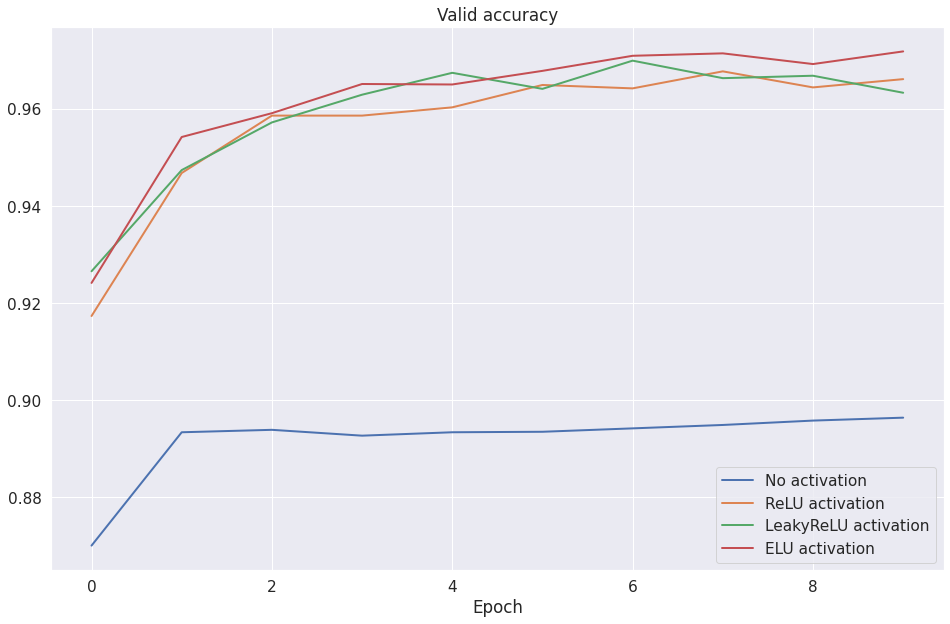

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

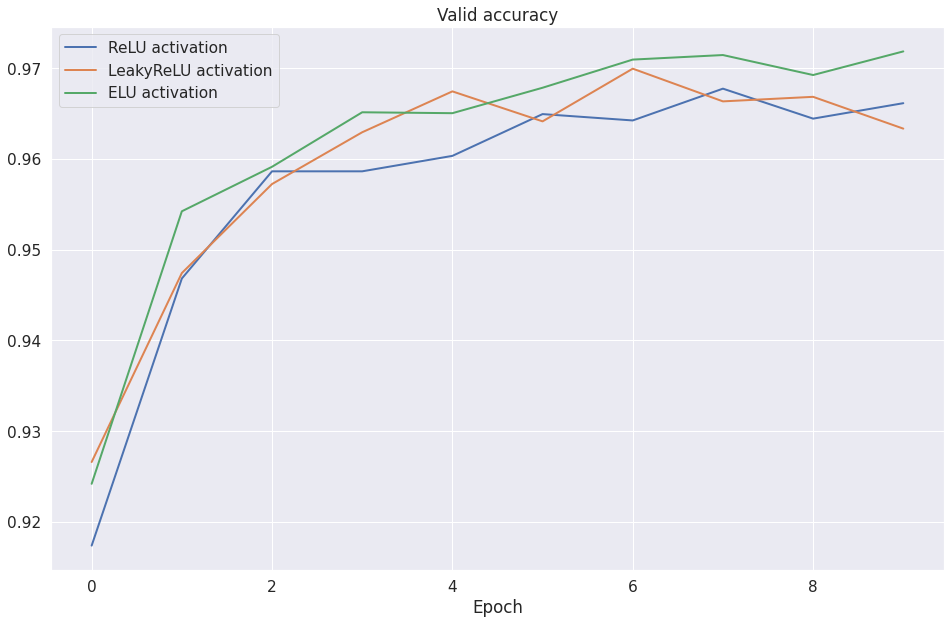

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
  print(f"ReLU:{max(relu_accuracy).round(4)} \nLeakyReLU: {max(leaky_relu_accuracy).round(4)}  \nELU: {max(elu_accuracy).round(4)}  ")


ReLU:0.9677 
LeakyReLU: 0.97  
ELU: 0.9719  


**Ответ:** После 10 эпох наилучший результат показала ELU > 0.97 

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-31 10:12:56--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-31 10:12:57--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   120KB/s    in 0.4s    

2022-10-31 10:12:58 (120 KB/s) - ‘sample_photo.jpg’ saved [49337/4

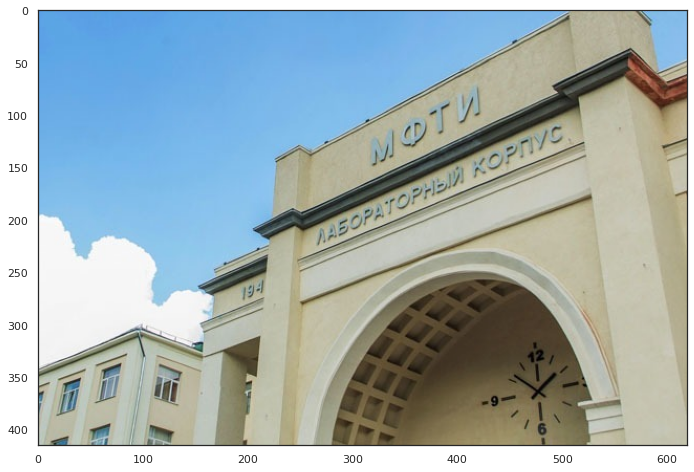

In [ ]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуем посмотреть как различные свертки влияют на фото. 

Например, попробуем:
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```


In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
 [0, 0, 0],
[0, 1, 0],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

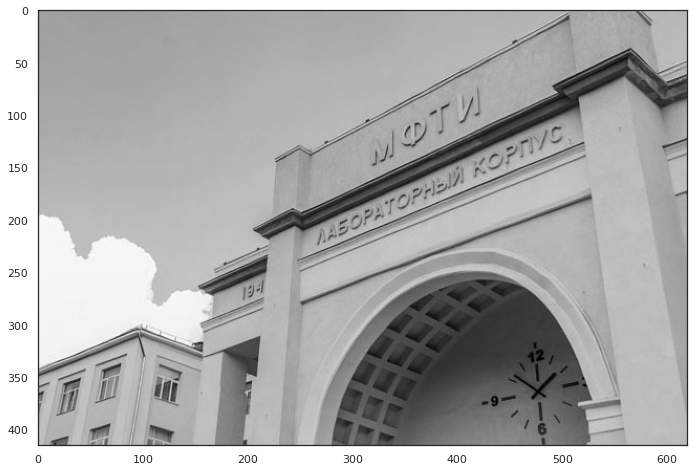

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

Как можно описать действия ядер, приведенных выше? 

Сопоставим для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 

1 - Е
2 - Д
3 - А
4 - В
5 - Б
6 - Г


###  Реализуем LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. 
На этот раз будем использовать модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x     

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(train_dataset, batch_size=128)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучим CNN

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              model.eval() 
              with torch.no_grad(): 
                outp = model(x_batch) 
            preds = outp.argmax(-1)
            correct = (preds == y_batch).cpu().numpy().sum()
            
            all = len(x_batch)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward() 
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
        

  

Epoch: 1
Loader: train. Accuracy: 0.87225
Loader: valid. Accuracy: 0.9540833333333333
Epoch: 2
Loader: train. Accuracy: 0.9634166666666667
Loader: valid. Accuracy: 0.9712
Epoch: 3
Loader: train. Accuracy: 0.9739166666666667
Loader: valid. Accuracy: 0.9791166666666666
Epoch: 4
Loader: train. Accuracy: 0.9799666666666667
Loader: valid. Accuracy: 0.9833
Epoch: 5
Loader: train. Accuracy: 0.9835666666666667
Loader: valid. Accuracy: 0.9872833333333333
Epoch: 6
Loader: train. Accuracy: 0.9867666666666667
Loader: valid. Accuracy: 0.9894166666666667
Epoch: 7
Loader: train. Accuracy: 0.9896
Loader: valid. Accuracy: 0.9907
Epoch: 8
Loader: train. Accuracy: 0.9911666666666666
Loader: valid. Accuracy: 0.9914833333333334
Epoch: 9
Loader: train. Accuracy: 0.9919666666666667
Loader: valid. Accuracy: 0.9911166666666666
Epoch: 10
Loader: train. Accuracy: 0.9927833333333334
Loader: valid. Accuracy: 0.99245


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

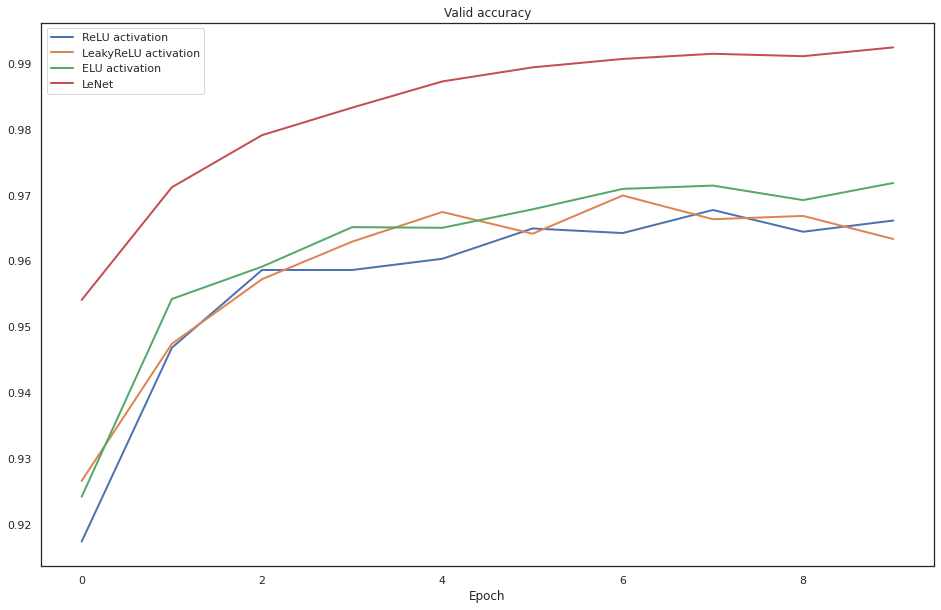

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
  print(f"ReLU:{max(relu_accuracy).round(2)} \nLeakyReLU: {max(leaky_relu_accuracy).round(2)} \nELU: {max(elu_accuracy).round(2)} \nLeNet: {max(lenet_accuracy).round(2)} ")

ReLU:0.97 
LeakyReLU: 0.97 
ELU: 0.97 
LeNet: 0.99 


**Получается accuracy = 0.99**



# Вывод:

Сверточные нейронные сети лучше подходят для работы с изображениям:
добавив несколько сверточных слоев, мы получили прирост в метрике accuracy с 0.97 до 0.99. 